# MEDIAR Prediction Tutorial

This tutorial guides how to conduct prediction using pretrained models with MEDIAR pipeline. Note that this is a inline version of running `predict.py` in MEDIAR repo.



---


## 1. Setup

Clone Github repository and install dependencies.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clone MEDIAR github repo
!git clone https://github.com/Lee-Gihun/MEDIAR.git
%rm -rf ./sample_data
%cd MEDIAR

# Install dependencies
%pip install -r requirements.txt
%pip install segmentation-models-pytorch==0.3.1
%pip install wandb
!wandb off

Cloning into 'MEDIAR'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 509 (delta 29), reused 36 (delta 17), pack-reused 460
Receiving objects: 100% (509/509), 15.30 MiB | 20.19 MiB/s, done.
Resolving deltas: 100% (268/268), done.
/content/MEDIAR
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.6/500.6 kB 56.6 MB/s eta 0:00:00
 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=43d1c04d16091e39a847076e7a8a1e6098ffa02ce9e352aacef0407ca88e8d05
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.




---


### 2. Prepare MEDIAR Models

MEDIAR uses two pretrained models to conduct ensemble prediction.

- Model1 : fine-tuned from "Phase 1" pretraining.
- Model2 : fine-tuned from "Phase 2" pretraining.

for the details on how each model is trained, [please refer to our Paper](https://arxiv.org/abs/2212.03465).


In [ ]:
# Download MEDIAR pretrained weights
%mkdir weights
!gdown https://drive.google.com/uc?id=1QtcC6D6UKwid2O2XIjEOTcFSB8TyzjAt -O weights/from_phase1.pth
!gdown https://drive.google.com/uc?id=1Mac8Q2XiRcUWXv9dbAgbPHcoI_TIhZx2 -O weights/from_phase2.pth

model_path1 = "./weights/from_phase1.pth"
model_path2 = "./weights/from_phase2.pth"

weights1 = torch.load(model_path1, map_location="cpu")
weights2 = torch.load(model_path2, map_location="cpu")

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QtcC6D6UKwid2O2XIjEOTcFSB8TyzjAt 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Mac8Q2XiRcUWXv9dbAgbPHcoI_TIhZx2 



NameError: ignored

We load weights on the our `MEDIARFormer` model.

`MEDIARFormer` predicts 3-dimensional outputs (3 classes), where each corresponds to:

- `Cell Recognition`: Predicts whether a pixel belongs to `cell (1)` or `background (0)`
- `Cell Distinction`: Horizontal Vector & Vertical Vector to the cell center.

In [ ]:
import torch
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np

from train_tools import *
from train_tools.models import MEDIARFormer
from core.MEDIAR import Predictor, EnsemblePredictor

model_args = {
    "classes": 3,
    "decoder_channels": [1024, 512, 256, 128, 64],
    "decoder_pab_channels": 256,
    "encoder_name": 'mit_b5',
    "in_channels": 3
}

model1 = MEDIARFormer(**model_args)
model1.load_state_dict(weights1, strict=False)

model2 = MEDIARFormer(**model_args)
model2.load_state_dict(weights2, strict=False)



---



### 3. Prepare Microscopy Data

We prepared 2 microscopy images in the `./input_path` directory. Let's see the images.

In [ ]:
input_path = "./images/examples"

img1 = io.imread(f"{input_path}/img1.tiff") #
io.imshow(img1)

In [ ]:
img2 = io.imread(f"{input_path}/img2.tif") #
io.imshow(img2)



---



### 4. Prediction - (1): Single Model

Let's detect the cell instances in the image using a single `MEDIARFormer` model.

- The `Predictor` conduct its pediction on all images in the `input_path` and save the results in the `output_path`.

- In this example, we do not use test-time Augmentation by setting `use_tta` as `False`.

In [ ]:
predictor = Predictor(model1, "cuda:0", input_path, output_path, algo_params={"use_tta": False})
_ = predictor.conduct_prediction()


The results are as follows:

In [ ]:
pred1 = io.imread("./output_path/img1_label.tiff")
io.imshow(pred1, cmap="cividis")

cell_count = len(np.unique(pred1))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")

In [ ]:
pred2 = io.imread("./output_path/img2_label.tiff")
io.imshow(pred2, cmap="cividis")

cell_count = len(np.unique(pred2))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")



---



### 5. Prediction - (2): Ensemble Model + TTA

Let's use the ensemble models with TTA.

- In this example, we use test-time Augmentation by setting `use_tta` as `True`.

It takes much longer, as it need to conduct multiple forward paths.

In [ ]:
predictor = EnsemblePredictor(model1, model2, "cuda:0", input_path, output_path, algo_params={"use_tta": True})
_ = predictor.conduct_prediction()

In [ ]:
pred1 = io.imread("./output_path/img1_label.tiff")
io.imshow(pred1, cmap="cividis")

cell_count = len(np.unique(pred1))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")

In [ ]:
pred2 = io.imread("./output_path/img2_label.tiff")
io.imshow(pred2, cmap="cividis")

cell_count = len(np.unique(pred2))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")



---

# Дата

In [ ]:
from PIL import ImageChops
from PIL import Image, ImageDraw
import numpy as np
import os
import json
import shutil

import zipfile
import os

# Path to the uploaded file
# zip_path = '/content/project-281-at-2023-10-24-22-21-0cda3a0f.zip'
zip_path = '/content/drive/MyDrive/Colab Notebooks/cropped.zip'
extract_path = '/content/data/dataset'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Path to the JSON file
json_path = os.path.join(extract_path, 'result.json')

# Reading the JSON file
with open(json_path, 'r') as json_file:
    coco_data = json.load(json_file)

# Path to save the label files
labels_path = '/content/data/dataset/labels'
os.makedirs(labels_path, exist_ok=True)

# Function to create a mask from segmentation data
def create_mask(width, height, segmentation):
    mask = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask)
    for segment in segmentation:
        draw.polygon(segment, outline=1, fill=1)
    return mask


# Creating masks for each image again
for img_info in coco_data['images']:
    img_id = img_info['id']
    img_width = img_info['width']
    img_height = img_info['height']
    img_name = img_info['file_name'].replace('\\', '/').split('/')[-1].split('.')[0]

    # Creating an empty mask for the image
    mask = Image.new('L', (img_width, img_height), 0)

    # Adding masks for each annotation
    for ann in coco_data['annotations']:
        if ann['image_id'] == img_id:
            segmentation = ann['segmentation']
            ann_mask = create_mask(img_width, img_height, segmentation)
            mask = ImageChops.add(mask, ann_mask)

    # Saving the mask as a .tiff file
    mask.save(os.path.join(labels_path, f'{img_name}_label.tiff'))


In [ ]:
# Path to the images folder
images_path = os.path.join(extract_path, 'images')

# Path to save the converted images
converted_images_path = '/content/data/dataset/converted_images'
os.makedirs(converted_images_path, exist_ok=True)

# Converting images to .tiff format
for img_file in os.listdir(images_path):
    if img_file.lower().endswith(('.tif', '.tiff')):
        # If the image is already in .tiff format, just copy it to the new folder
        shutil.copy(os.path.join(images_path, img_file), os.path.join(converted_images_path, img_file))
    else:
        # If the image is not in .tiff format, convert and save it as .tiff
        img_path = os.path.join(images_path, img_file)
        img = Image.open(img_path)
        img_name = img_file.split('.')[0]
        img.save(os.path.join(converted_images_path, f'{img_name}.tiff'), 'TIFF')


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Путь к папке с изображениями
images_path = '/content/data/dataset/images'

# Путь к папке с разметкой
labels_path = '/content/data/dataset/labels'

# Название файла изображения (без расширения)
image_name = '0a126a2b-frame_204'

# Загрузка изображения и разметки
image = Image.open(f'{images_path}/{image_name}.png')
label = Image.open(f'{labels_path}/{image_name}_label.tiff')

# Визуализация изображения
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(label, cmap='gray')
plt.title('Разметка')
plt.axis('off')

plt.show()

FileNotFoundError: ignored

In [ ]:
/content/MEDIAR/generate_mapping.py
import os, glob
import json
import argparse


def public_paths_labeled(root):
    """Map paths for public datasets as dictionary list"""

    images_raw = sorted(glob.glob(os.path.join(root, "Public/images/*")))
    labels_raw = sorted(glob.glob(os.path.join(root, "Public/labels/*")))

    data_dicts = []

    for image_path, label_path in zip(images_raw, labels_raw):
        name1 = image_path.split("/")[-1].split(".")[0]
        name2 = label_path.split("/")[-1].split("_label")[0]
        assert name1 == name2

        data_item = {
            "img": image_path.split("CellSeg/")[-1],
            "label": label_path.split("CellSeg/")[-1],
        }

        data_dicts.append(data_item)

    map_dict = {"public": data_dicts}

    return map_dict


def official_paths_labeled(root):
    """Map paths for official labeled datasets as dictionary list"""

    image_path = os.path.join(root, "converted_images/*")
    label_path = os.path.join(root, "labels/*")

    images_raw = sorted(glob.glob(image_path))
    labels_raw = sorted(glob.glob(label_path))

    data_dicts = []

    for image_path, label_path in zip(images_raw, labels_raw):
        name1 = image_path.split("/")[-1].split(".")[0]
        name2 = label_path.split("/")[-1].split("_label")[0]
        assert name1 == name2

        data_item = {
            "img": image_path.split("CellSeg/")[-1],
            "label": label_path.split("CellSeg/")[-1],
        }

        data_dicts.append(data_item)

    map_dict = {"official": data_dicts}

    return map_dict


def official_paths_tuning(root):
    """Map paths for official tuning datasets as dictionary list"""

    image_path = os.path.join(root, "Official/TuningSet/*")
    images_raw = sorted(glob.glob(image_path))

    data_dicts = []

    for image_path in images_raw:
        data_item = {"img": image_path.split("CellSeg/")[-1]}
        data_dicts.append(data_item)

    map_dict = {"official": data_dicts}

    return map_dict


def add_mapping_to_json(json_file, map_dict):
    """Save mapped dictionary as a json file"""

    if not os.path.exists(json_file):
        with open(json_file, "w") as file:
            json.dump({}, file)

    with open(json_file, "r") as file:
        data = json.load(file)

    for map_key, map_item in map_dict.items():
        if map_key not in data.keys():
            data[map_key] = map_item
        else:
            print('>>> "{}" already exists in path map keys...'.format(map_key))

    with open(json_file, "w") as file:
        json.dump(data, file)


if __name__ == "__main__":
    # [!Caution] The paths should be overrided for the local environment!
    parser = argparse.ArgumentParser(description="Mapping files and paths")
    parser.add_argument("--root", default=".", type=str)
    args = parser.parse_args()

    MAP_DIR = "./train_tools/data_utils/"

    print("\n----------- Path Mapping for Labeled Data is Started... -----------\n")

    map_labeled = os.path.join(MAP_DIR, "mapping_labeled.json")
    map_dict = official_paths_labeled(args.root)
    add_mapping_to_json(map_labeled, map_dict)

    print("\n----------- Path Mapping for Tuning Data is Started... -----------\n")

    map_labeled = os.path.join(MAP_DIR, "mapping_tuning.json")
    map_dict = official_paths_tuning(args.root)
    add_mapping_to_json(map_labeled, map_dict)

    print("\n----------- Path Mapping for Public Data is Started... -----------\n")

    map_public = os.path.join(MAP_DIR, "mapping_public.json")
    map_dict = public_paths_labeled(args.root)
    add_mapping_to_json(map_public, map_dict)

    print("\n-------------- Path Mapping is Ended !!! ---------------------------\n")


In [ ]:
/content/MEDIAR/config/step2_finetuning/finetuning1.json
{
    "data_setups":{
        "labeled":{
            "root": "/home/gihun/data/CellSeg/",
            "mapping_file": "./train_tools/data_utils/mapping_labeled.json",
            "mapping_file_tuning": "./train_tools/data_utils/mapping_tuning.json",
            "amplified": false,
            "batch_size": 4,
            "valid_portion": 0.15
        },
        "public":{
            "enabled": false
        },
        "unlabeled":{
            "enabled": false
        }
    },
    "train_setups":{
        "model":{
            "name": "mediar-former",
            "params": {},
            "pretrained":{
                "enabled": true,
                "weights": "./weights/pretrained/phase1.pth",
                "strict": false
            }
        },
        "trainer": {
            "name": "mediar",
            "params": {
                "num_epochs": 25,
                "valid_frequency": 1,
                "device": "cuda:0",
                "amp": true,
                "algo_params": {"with_public": true}
            }
        },
        "optimizer":{
            "name": "adamw",
            "params": {"lr": 2e-5}
        },
        "scheduler":{
            "enabled": true,
            "name": "cosine",
            "params": {"T_max": 100, "eta_min": 1e-7}
        },
        "seed": 19940817
    },
    "pred_setups":{
        "input_path":"/content/MEDIAR/image/examples",
        "output_path": "./results/",
        "make_submission": true,
        "exp_name": "mediar_from_phase1",
        "algo_params": {"use_tta": false}
    },
    "wandb_setups":{
        "project": "CellSeg",
        "group": "Fine-tuning",
        "name": "from_phase1"
    }
}

In [ ]:
/content/MEDIAR/core/MEDIAR/Trainer.py
import torch
import torch.nn as nn
import numpy as np
import os, sys
from tqdm import tqdm
from monai.inferers import sliding_window_inference

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))

from core.BaseTrainer import BaseTrainer
from core.MEDIAR.utils import *

__all__ = ["Trainer"]


class Trainer(BaseTrainer):
    def __init__(
        self,
        model,
        dataloaders,
        optimizer,
        scheduler=None,
        criterion=None,
        num_epochs=100,
        device="cuda:0",
        no_valid=False,
        valid_frequency=1,
        amp=False,
        algo_params=None,
    ):
        super(Trainer, self).__init__(
            model,
            dataloaders,
            optimizer,
            scheduler,
            criterion,
            num_epochs,
            device,
            no_valid,
            valid_frequency,
            amp,
            algo_params,
        )

        self.mse_loss = nn.MSELoss(reduction="mean")
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="mean")

    def mediar_criterion(self, outputs, labels_onehot_flows):
        """loss function between true labels and prediction outputs"""

        # Cell Recognition Loss
        cellprob_loss = self.bce_loss(
            outputs[:, -1],
            torch.from_numpy(labels_onehot_flows[:, 1] > 0.5).to(self.device).float(),
        )

        # Cell Distinction Loss
        gradient_flows = torch.from_numpy(labels_onehot_flows[:, 2:]).to(self.device)
        gradflow_loss = 0.5 * self.mse_loss(outputs[:, :2], 5.0 * gradient_flows)

        loss = cellprob_loss + gradflow_loss

        return loss

    def _epoch_phase(self, phase):
        phase_results = {}

        # Set model mode
        self.model.train() if phase == "train" else self.model.eval()

        # Epoch process
        for batch_data in tqdm(self.dataloaders[phase]):
            images, labels = batch_data["img"], batch_data["label"]

            # if self.with_public:
            #     # Load batches sequentially from the unlabeled dataloader
            #     try:
            #         batch_data = next(self.public_iterator)
            #         images_pub, labels_pub = batch_data["img"], batch_data["label"]

            #     except:
            #         # Assign memory loader if the cycle ends
            #         self.public_iterator = iter(self.public_loader)
            #         batch_data = next(self.public_iterator)
            #         images_pub, labels_pub = batch_data["img"], batch_data["label"]

            #     # Concat memory data to the batch
            #     images = torch.cat([images, images_pub], dim=0)
            #     labels = torch.cat([labels, labels_pub], dim=0)

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            with torch.cuda.amp.autocast(enabled=self.amp):
                with torch.set_grad_enabled(phase == "train"):
                    # Output shape is B x [grad y, grad x, cellprob] x H x W
                    outputs = self._inference(images, phase)

                    # Map label masks to graidnet and onehot
                    labels_onehot_flows = labels_to_flows(
                        labels, use_gpu=True, device=self.device
                    )
                    # Calculate loss
                    loss = self.mediar_criterion(outputs, labels_onehot_flows)
                    self.loss_metric.append(loss)

                    # Calculate valid statistics
                    if phase != "train":
                        outputs, labels = self._post_process(outputs, labels)
                        f1_score = self._get_f1_metric(outputs, labels)
                        self.f1_metric.append(f1_score)

                # Backward pass
                if phase == "train":
                    # For the mixed precision training
                    if self.amp:
                        self.scaler.scale(loss).backward()
                        self.scaler.unscale_(self.optimizer)
                        self.scaler.step(self.optimizer)
                        self.scaler.update()

                    else:
                        loss.backward()
                        self.optimizer.step()

        # Update metrics
        phase_results = self._update_results(
            phase_results, self.loss_metric, "dice_loss", phase
        )
        if phase != "train":
            phase_results = self._update_results(
                phase_results, self.f1_metric, "f1_score", phase
            )

        return phase_results

    def _inference(self, images, phase="train"):
        """inference methods for different phase"""

        if phase != "train":
            outputs = sliding_window_inference(
                images,
                roi_size=512,
                sw_batch_size=4,
                predictor=self.model,
                padding_mode="constant",
                mode="gaussian",
                overlap=0.5,
            )
        else:
            outputs = self.model(images)

        return outputs

    def _post_process(self, outputs, labels=None):
        """Predict cell instances using the gradient tracking"""
        outputs = outputs.squeeze(0).cpu().numpy()
        gradflows, cellprob = outputs[:2], self._sigmoid(outputs[-1])
        outputs = compute_masks(gradflows, cellprob, use_gpu=True, device=self.device)
        outputs = outputs[0]  # (1, C, H, W) -> (C, H, W)

        if labels is not None:
            labels = labels.squeeze(0).squeeze(0).cpu().numpy()

        return outputs, labels

    def _sigmoid(self, z):
        """Sigmoid function for numpy arrays"""
        return 1 / (1 + np.exp(-z))


# Трейн

In [ ]:
!python ./generate_mapping.py --root=/content/data/dataset


----------- Path Mapping for Labeled Data is Started... -----------


----------- Path Mapping for Tuning Data is Started... -----------


----------- Path Mapping for Public Data is Started... -----------


-------------- Path Mapping is Ended !!! ---------------------------



In [ ]:
%mkdir weights
%mkdir weights/pretrained
!gdown https://drive.google.com/uc?id=1v5tYYJDqiwTn_mV0KyX5UEonlViSNx4i -O weights/pretrained/phase1.pth

Downloading...
From: https://drive.google.com/uc?id=1v5tYYJDqiwTn_mV0KyX5UEonlViSNx4i
To: /content/MEDIAR/weights/pretrained/phase1.pth
100% 486M/486M [00:03<00:00, 122MB/s]


In [ ]:
!pwd

/content/MEDIAR


In [ ]:
# %cd MEDIAR/

In [ ]:
!python ./main.py --config_path=/content/MEDIAR/config/step2_finetuning/finetuning1.json


================================================== Configuration ==================================================
{'data_setups': {'labeled': {'amplified': False,
                             'batch_size': 4,
                             'mapping_file': './train_tools/data_utils/mapping_labeled.json',
                             'mapping_file_tuning': './train_tools/data_utils/mapping_tuning.json',
                             'root': '/home/gihun/data/CellSeg/',
                             'valid_portion': 0.15},
                 'public': {'enabled': False},
                 'unlabeled': {'enabled': False}},
 'pred_setups': {'algo_params': {'use_tta': False},
                 'exp_name': 'mediar_from_phase1',
                 'input_path': '/content/MEDIAR/image/examples',
                 'make_submission': True,
                 'output_path': './results/'},
 'train_setups': {'model': {'name': 'mediar-former',
                            'params': {},
                         

In [ ]:
!cp -r /content/MEDIAR/wandb/offline-run-20231210_213839-8yp153rh /content/drive/MyDrive/Bio/Mediar2_only_cropped

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Путь к папке с изображениями
images_path = '/content/MEDIAR/image/examples/photo_2023-12-04_01-29-22.jpg'

# Путь к папке с разметкой
labels_path = '/content/MEDIAR/results/photo_2023-12-04_01-29-22_label.tiff'

# Название файла изображения (без расширения)
image_name = '1832558f-img00468'

# Загрузка изображения и разметки
image = Image.open(images_path)
label = Image.open(labels_path)

# Визуализация изображения
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(label)
plt.title('Разметка')
plt.axis('off')

plt.show()

# Inference

In [ ]:
%cd MEDIAR

[Errno 2] No such file or directory: 'MEDIAR'
/content/MEDIAR


In [ ]:
import torch
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np

from train_tools import *
from train_tools.models import MEDIARFormer
from core.MEDIAR import Predictor, EnsemblePredictor

model_args = {
    "classes": 3,
    "decoder_channels": [1024, 512, 256, 128, 64],
    "decoder_pab_channels": 256,
    "encoder_name": 'mit_b5',
    "in_channels": 3
}

weights1 = torch.load("/content/drive/MyDrive/Bio/mediar1_full/files/model.pth", map_location="cpu")
weights2 = torch.load("/content/drive/MyDrive/Bio/mediar2_full/files/model.pth", map_location="cpu")

model1 = MEDIARFormer(**model_args)
model1.load_state_dict(weights1, strict=False)

model2 = MEDIARFormer(**model_args)
model2.load_state_dict(weights2, strict=False)

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b5.pth" to /root/.cache/torch/hub/checkpoints/mit_b5.pth


  0%|          | 0.00/313M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
from PIL import Image

def convert_png_to_tiff(input_path, output_path):
    try:
        # Open the PNG image
        with Image.open(input_path) as img:
            # Save the image as a TIFF file
            img.save(output_path, 'TIFF')
        print(f"Conversion successful. TIFF image saved at {output_path}")
    except Exception as e:
        print(f"Error: {e}")

# Example usage:
input_png_path = '/content//test.png'
output_tiff_path = '/content/in/test.tiff'

convert_png_to_tiff(input_png_path, output_tiff_path)

Conversion successful. TIFF image saved at /content/in/test.tiff


In [ ]:
from PIL import Image
import os

def convert_pngs_to_tiff(input_dir, output_dir):
    try:
        # Create the output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Iterate through all files in the input directory
        for filename in os.listdir(input_dir):
            input_path = os.path.join(input_dir, filename)

            # Check if the file is a PNG image
            if os.path.isfile(input_path) and filename.lower().endswith('.png'):
                # Construct the output path with the same filename but TIFF extension
                output_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.tiff')

                # Open the PNG image and save it as a TIFF file
                with Image.open(input_path) as img:
                    img.save(output_path, 'TIFF')
                print(f"Conversion successful. TIFF image saved at {output_path}")

    except Exception as e:
        print(f"Error: {e}")

# Example usage:
input_png_directory = '/content/test'
output_tiff_directory = '/content/input'

convert_pngs_to_tiff(input_png_directory, output_tiff_directory)

Conversion successful. TIFF image saved at /content/input/frame_23.tiff
Conversion successful. TIFF image saved at /content/input/frame_42.tiff
Conversion successful. TIFF image saved at /content/input/frame_20.tiff
Conversion successful. TIFF image saved at /content/input/frame_27.tiff
Conversion successful. TIFF image saved at /content/input/frame_19.tiff
Conversion successful. TIFF image saved at /content/input/frame_41.tiff
Conversion successful. TIFF image saved at /content/input/frame_22.tiff
Conversion successful. TIFF image saved at /content/input/frame_37.tiff
Conversion successful. TIFF image saved at /content/input/frame_24.tiff
Conversion successful. TIFF image saved at /content/input/frame_15.tiff
Conversion successful. TIFF image saved at /content/input/frame_21.tiff
Conversion successful. TIFF image saved at /content/input/frame_25.tiff
Conversion successful. TIFF image saved at /content/input/frame_0.tiff
Conversion successful. TIFF image saved at /content/input/frame_1

In [ ]:
input_path = "/content/input"
output_path = "/content/output"
#predictor = Predictor(model2, "cuda:0", input_path, output_path, algo_params={"use_tta": False})
#_ = predictor.conduct_prediction()
predictor = EnsemblePredictor(model1, model2, "cuda:0", input_path, output_path, algo_params={"use_tta": False})
_ = predictor.conduct_prediction()

Prediction finished: frame_0.tiff; img size = torch.Size([1, 3, 1200, 1920]); costing: 12.15s
Prediction finished: frame_10.tiff; img size = torch.Size([1, 3, 1200, 1920]); costing: 11.97s
Prediction finished: frame_13.tiff; img size = torch.Size([1, 3, 300, 500]); costing: 0.63s
Prediction finished: frame_14.tiff; img size = torch.Size([1, 3, 300, 500]); costing: 0.60s
Prediction finished: frame_15.tiff; img size = torch.Size([1, 3, 300, 500]); costing: 0.47s
Prediction finished: frame_16.tiff; img size = torch.Size([1, 3, 300, 500]); costing: 0.45s
Prediction finished: frame_17.tiff; img size = torch.Size([1, 3, 300, 500]); costing: 0.45s
Prediction finished: frame_18.tiff; img size = torch.Size([1, 3, 300, 500]); costing: 0.46s
Prediction finished: frame_19.tiff; img size = torch.Size([1, 3, 300, 500]); costing: 0.44s
Prediction finished: frame_2.tiff; img size = torch.Size([1, 3, 1200, 1920]); costing: 11.45s
Prediction finished: frame_20.tiff; img size = torch.Size([1, 3, 300, 500

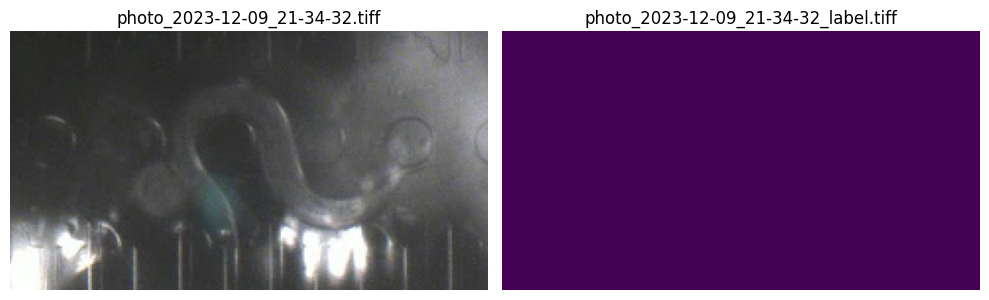

In [ ]:
import matplotlib.pyplot as plt
import os
from skimage import io

# Define the paths for the images
name = "photo_2023-12-09_21-34-32"
image_paths = [
    f'/content/in/{name}.tiff',
    f"/content/out/{name}_label.tiff"
]

# Load the images
images = [io.imread(path) for path in image_paths]

# Display the images in one figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

for ax, img, path in zip(axes.flatten(), images, image_paths):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.basename(path))

plt.tight_layout()
plt.show()

In [ ]:
pred = io.imread("/content/out/0ea93106-frame_340_label.tiff")
io.imshow(pred)

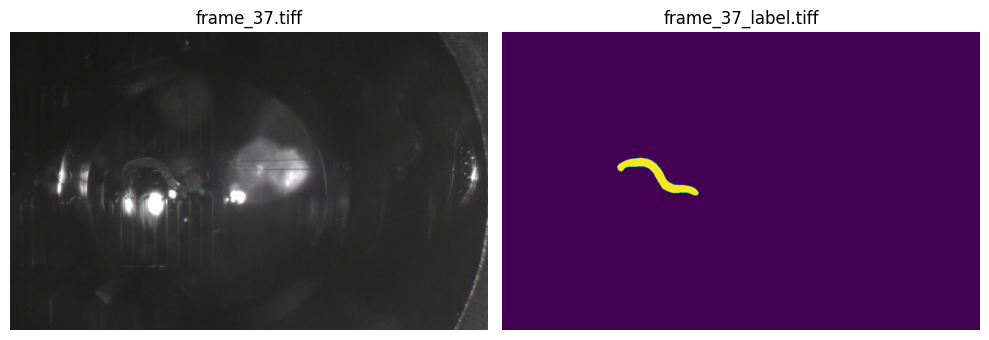

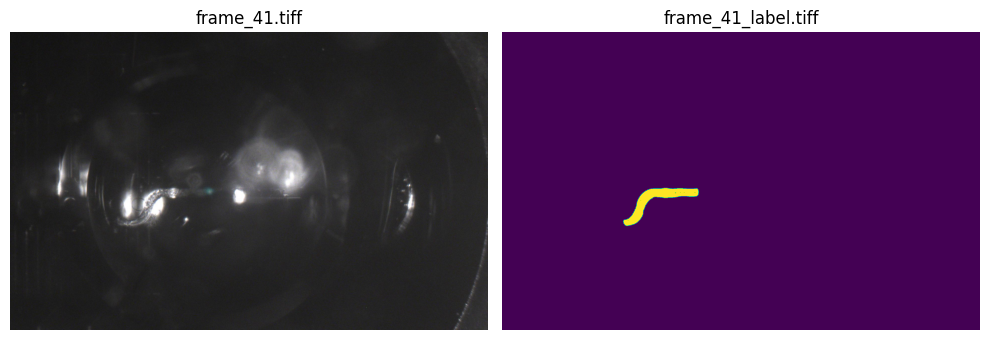

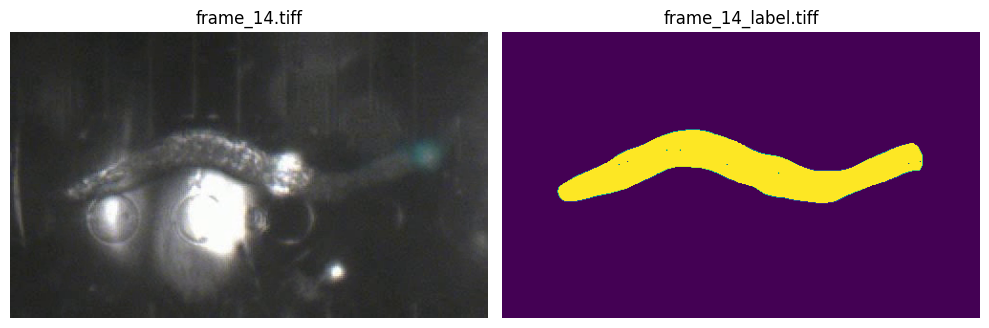

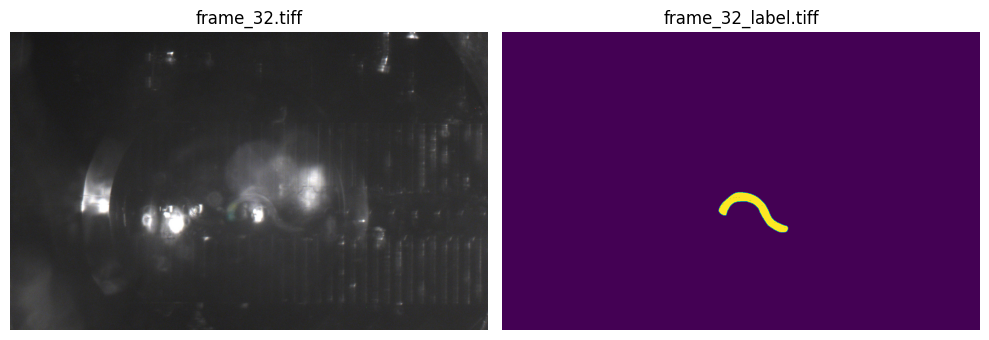

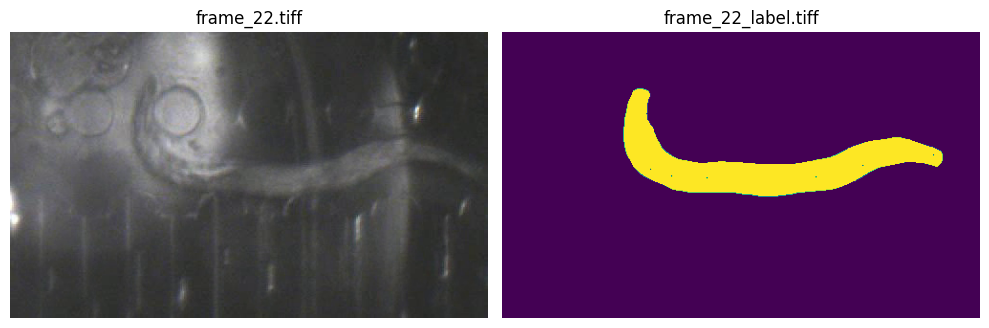

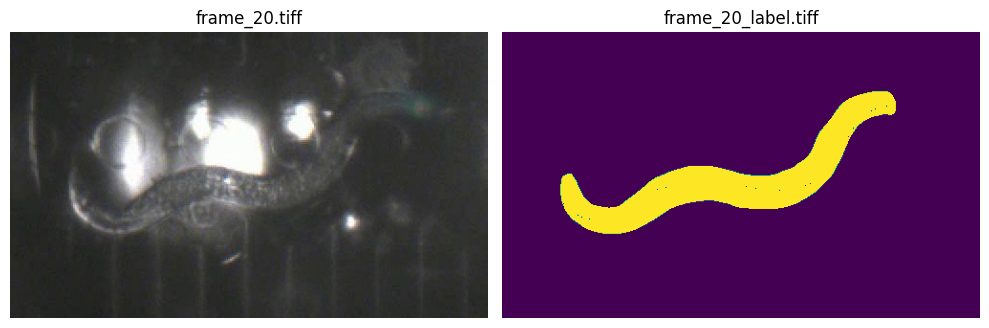

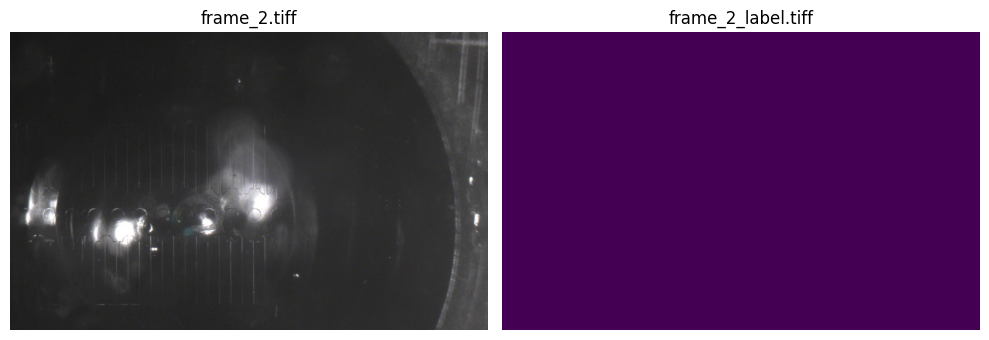

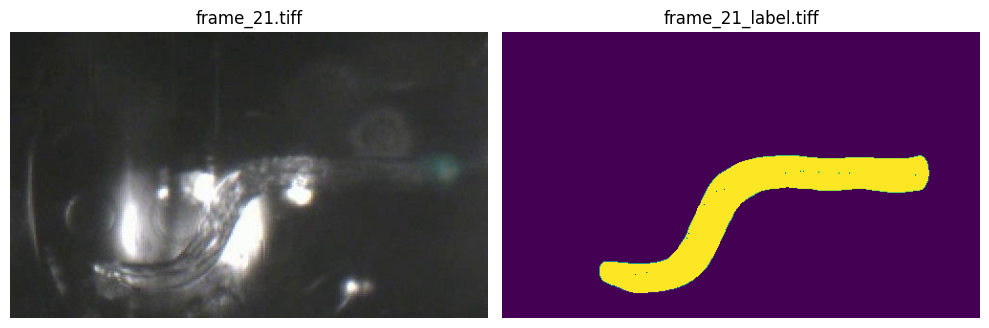

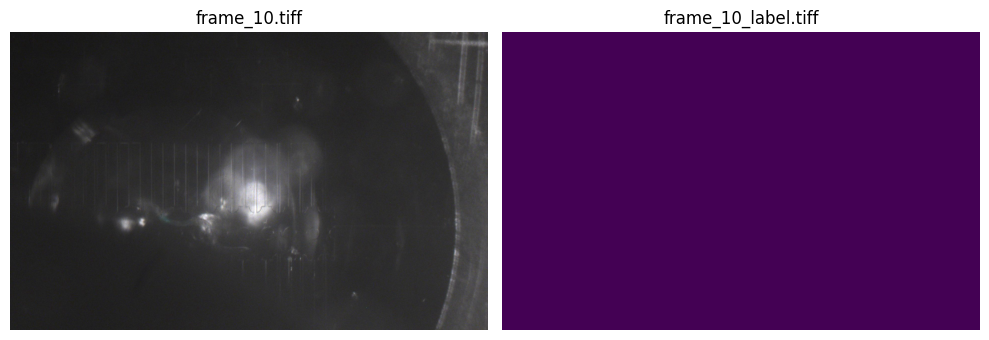

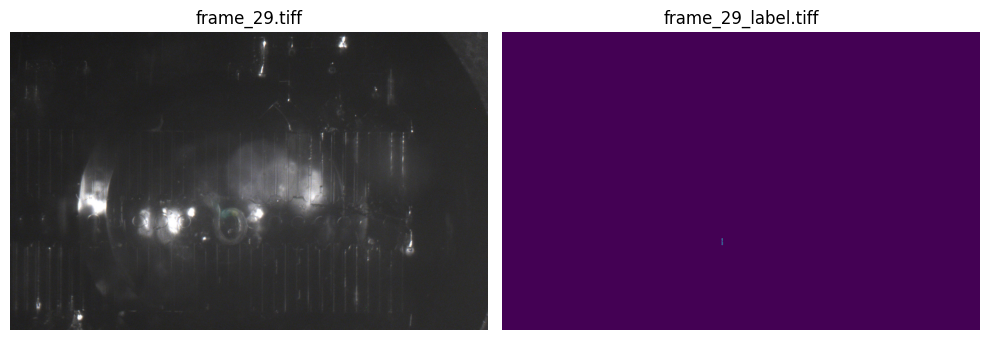

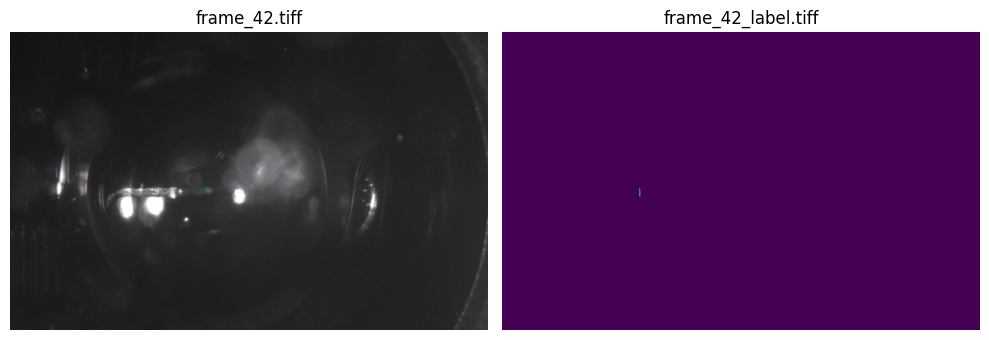

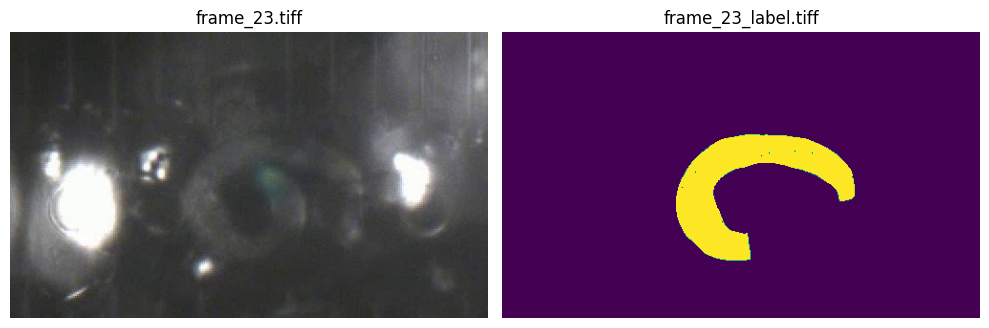

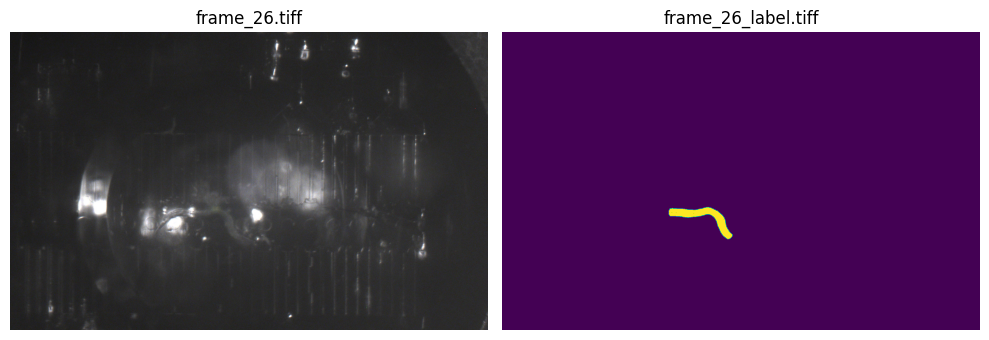

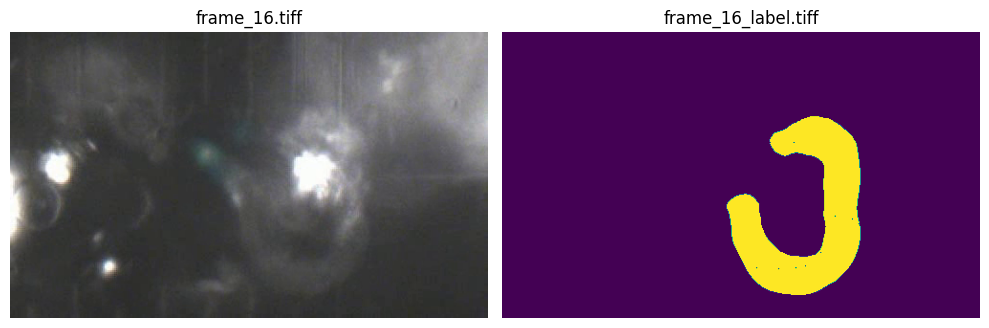

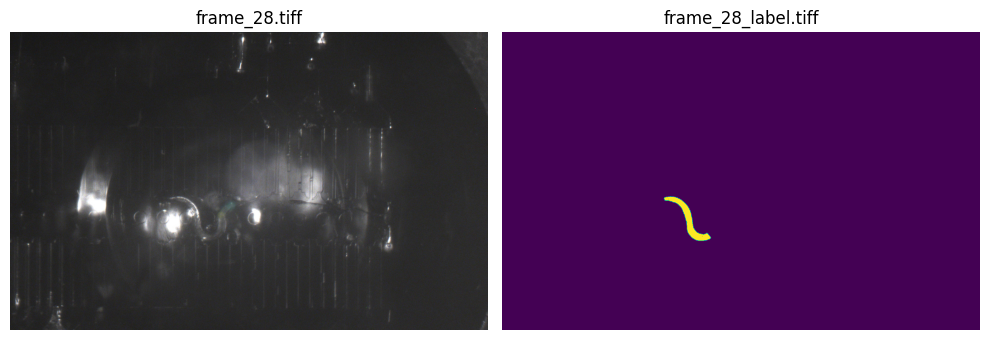

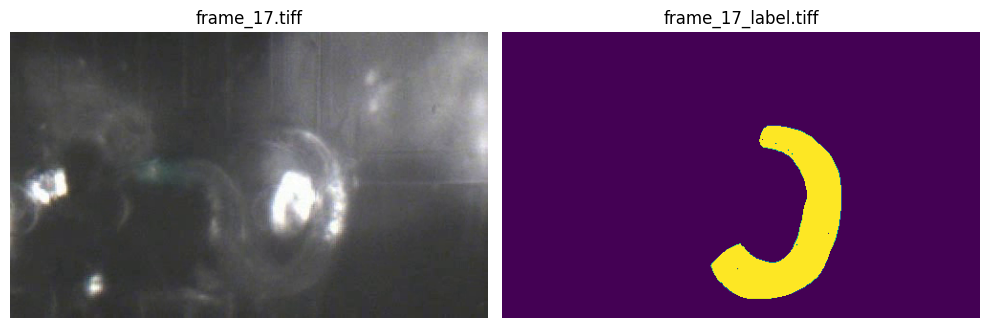

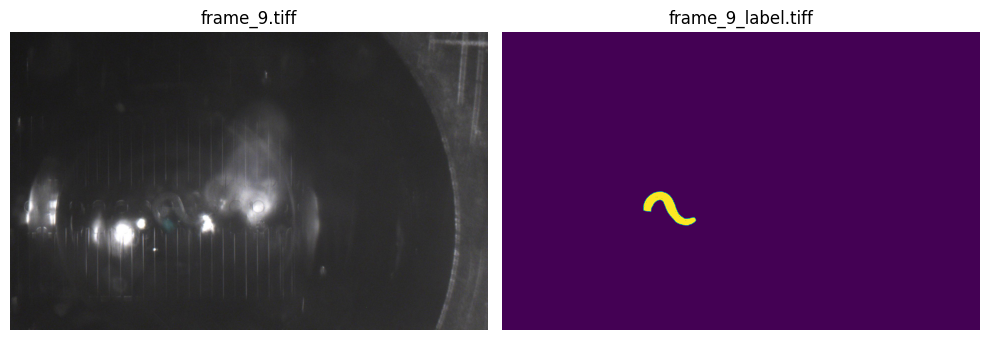

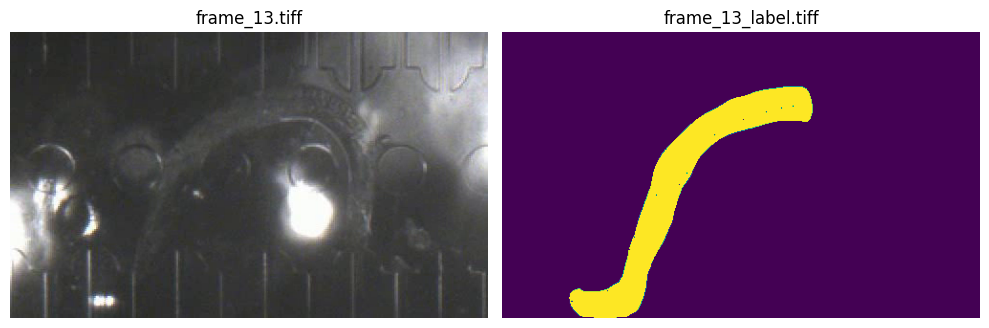

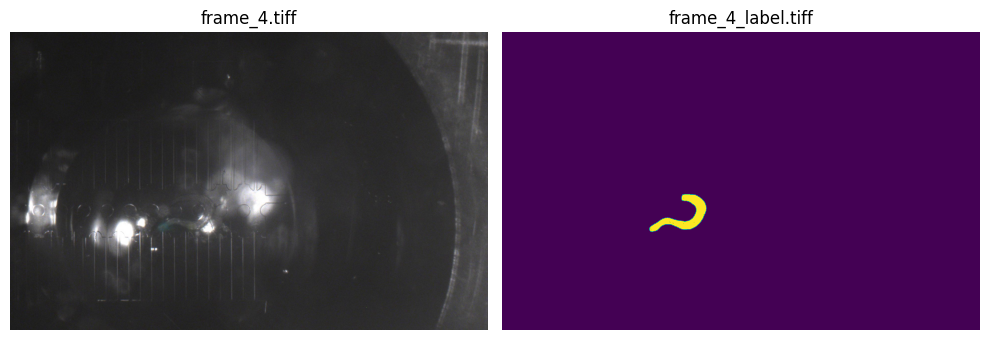

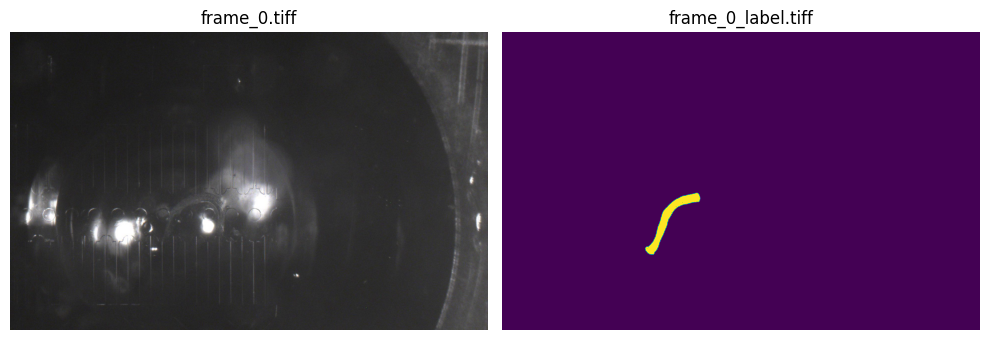

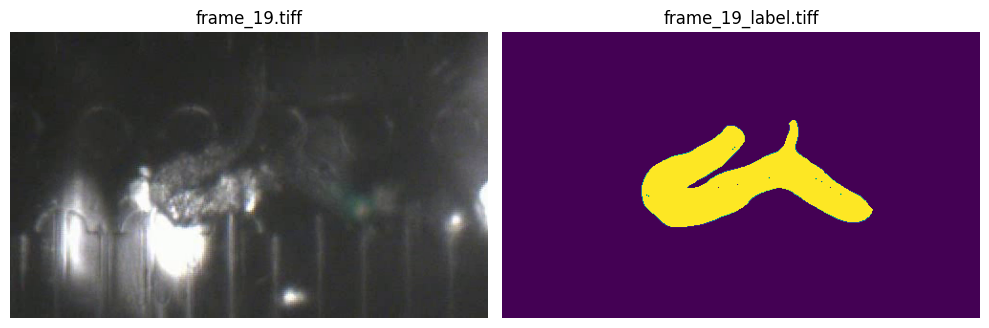

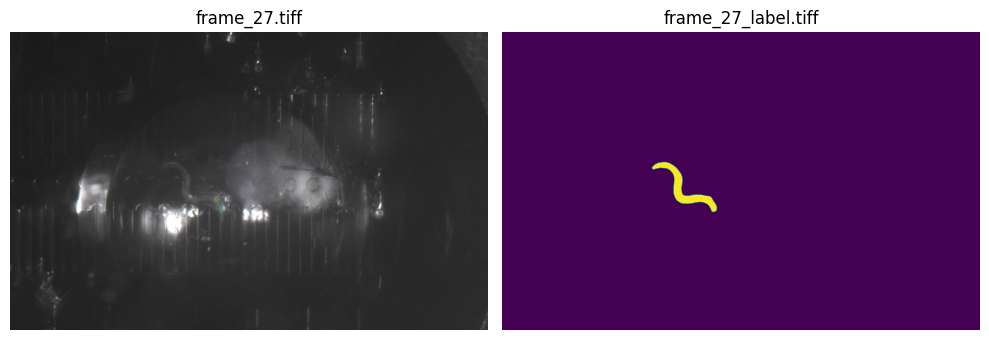

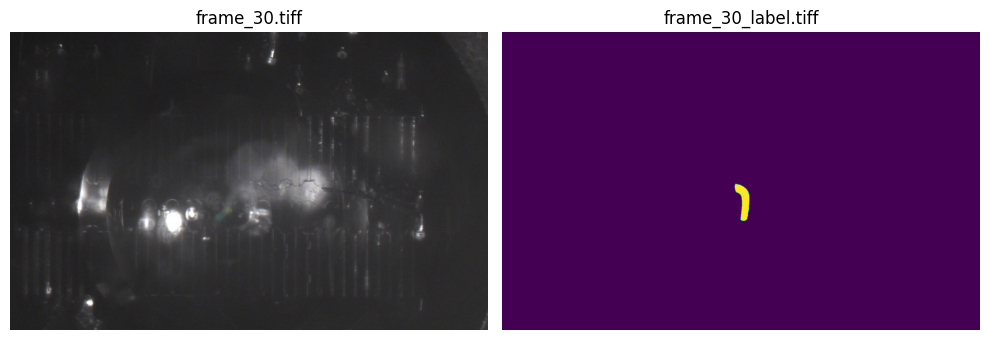

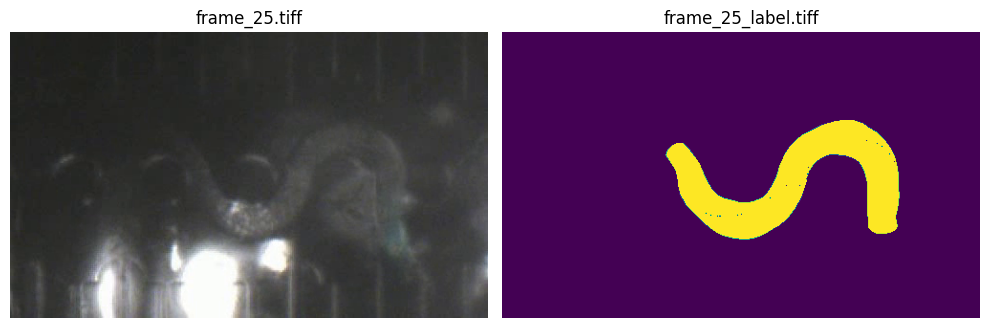

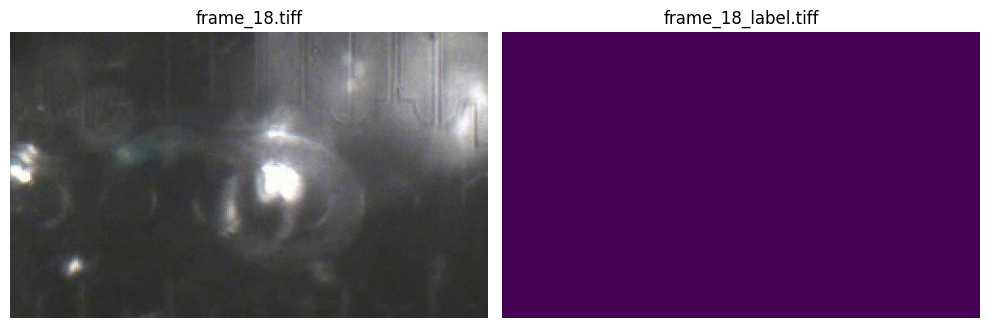

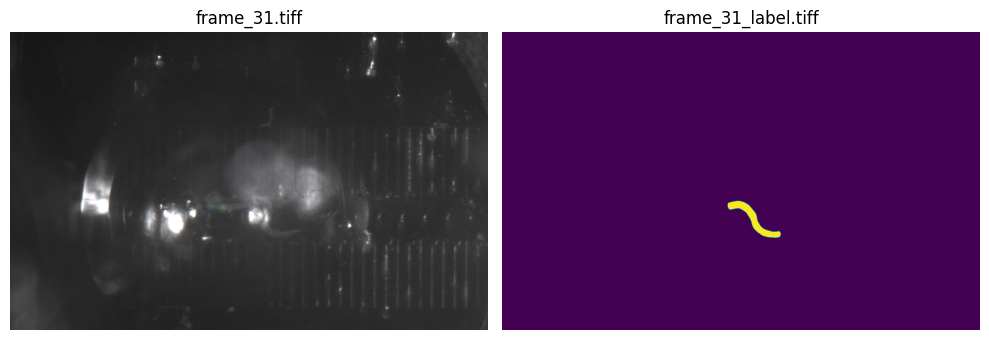

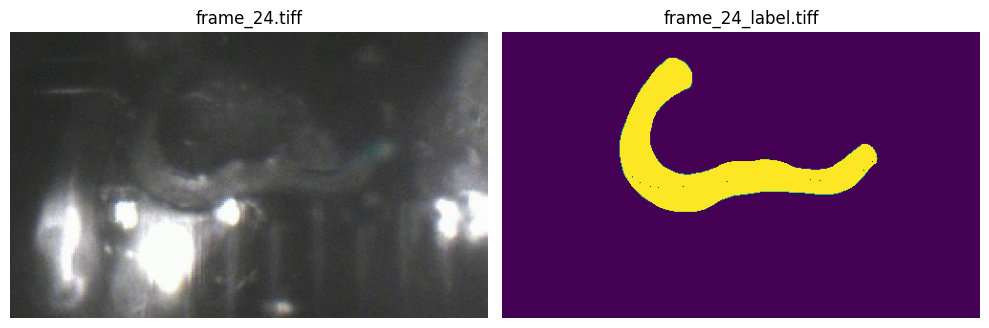

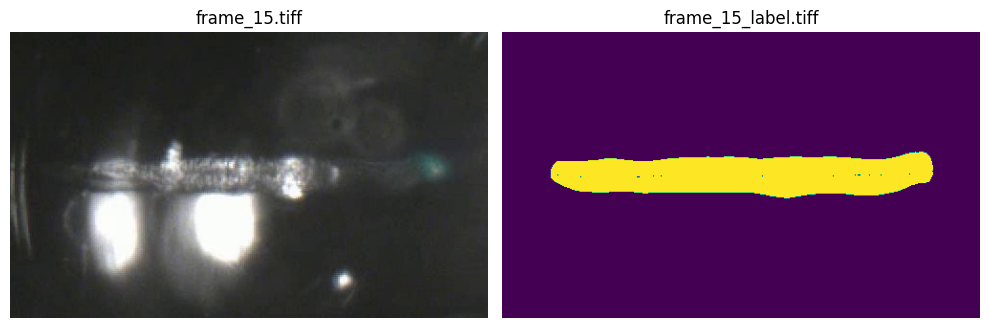

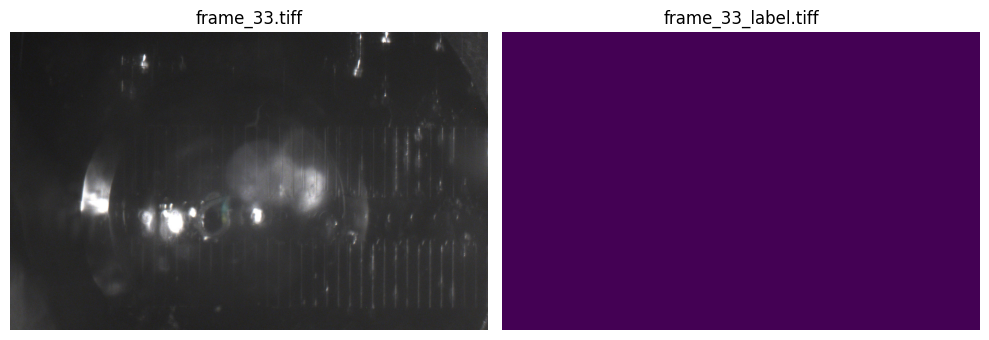

In [ ]:
import matplotlib.pyplot as plt
import os
from skimage import io

directory_path = '/content/output'

# Iterate through all filenames in the directory
for filename in os.listdir(directory_path):
    # Full path to the file
    full_path = os.path.join(directory_path, filename)
# Define the paths for the images

    image_paths = [
        full_path.replace('_label', '').replace('out','in'),
        full_path
    ]

    # Load the images
    images = [io.imread(path) for path in image_paths]

    # Display the images in one figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))

    for ax, img, path in zip(axes.flatten(), images, image_paths):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(path))

    plt.tight_layout()
    plt.show()
